# Multi Digit Number Recognition with SVHN .In Which Data quality is quite similar




In [ ]:
from __future__ import print_function
import numpy as np

from six.moves import cPickle as pickle
from six.moves import range

import os
import sys
import tarfile
from IPython.display import display, Image

import h5py

import matplotlib.pyplot as plt

from PIL import Image
import random
from urllib import urlretrieve

In [ ]:
from collections import Counter

In [ ]:
%matplotlib inline

In [ ]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent

def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

train_filename = maybe_download('train.tar.gz', 404141560 )
test_filename = maybe_download('test.tar.gz', 276555967 )

Attempting to download: train.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified train.tar.gz
Attempting to download: test.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified test.tar.gz


In [ ]:
num_classes = 10
np.random.seed(133)

train_filename = 'train.tar.gz'
test_filename = 'test.tar.gz'
def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0] 
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    if not os.path.exists(root+'/digitStruct.mat'):
        print("digitStruct.mat is missing")
    return root + '/digitStruct.mat'
  
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for train. This may take a while. Please wait.
Extracting data for test. This may take a while. Please wait.


In [ ]:
train_dataset = h5py.File(train_folders, "r")
train_dataset["digitStruct"].items()

[(u'bbox', <HDF5 dataset "bbox": shape (33402, 1), type "|O">),
 (u'name', <HDF5 dataset "name": shape (33402, 1), type "|O">)]

In [ ]:
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s  
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [ ]:
print(train_folders)
train = DigitStructFile(train_folders)
train_data = train.getAllDigitStructure_ByDigit()


test = DigitStructFile(test_folders)
test_data = test.getAllDigitStructure_ByDigit()

train/digitStruct.mat


In [ ]:
pickle_file = 'multi_bbox_info.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_data': train_data,
    'test_data': test_data,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [ ]:
pickle_file = 'multi_bbox_info.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_data = save['train_data']
    test_data = save['test_data']
    del save
    print('Training set', len(train_data))
    print('Test set', len(test_data))

Training set 33402
Test set 13068


In [ ]:
class Dataset:
    """crop images and save them to numpy ndarray"""
    
    def __init__(self, digitStruct, folder):
        self.digitStruct = digitStruct
        self.folder = folder
        
    def setDataset(self):
        self.dataset = np.ndarray(shape=(len(self.digitStruct), 64, 64), dtype='float32')
        self.labels = np.ones(shape=(len(self.digitStruct), 5), dtype='int') * 10 
        
    def getDataset(self):
        
        self.setDataset()
        
        for i in range(len(self.digitStruct)):

            fin = os.path.join(self.folder, self.digitStruct[i]['filename'])
            im = Image.open(fin)
            
            boxes = self.digitStruct[i]['boxes']
            
            if len(boxes) > 5:
                print(fin, "has more than 5 digits")
            else:
                self.labels[i,0:len(boxes)] = [int(j['label']) for j in boxes]
            
            left = [j['left'] for j in boxes]
            top = [j['top'] for j in boxes]
            height = [j['height'] for j in boxes]
            width = [j['width'] for j in boxes]
            
            box = self.img_box(im, left, top, height, width)

            size = (64, 64)
            region = im.crop(box).resize(size)
            region = self.normalization(region)
            self.dataset[i,:,:] = region[:,:]
            
        print('dataset:',self.dataset.shape)
        print('labels:',self.labels.shape)
        return self.dataset, self.labels
        
    def img_box(self, im, left, top, height, width):

        im_left = min(left)
        im_top = min(top)
        im_height = max(top) + max(height) - im_top
        im_width = max(left) + max(width) - im_left

        im_top = im_top - im_height * 0.05 
        im_left = im_left - im_width * 0.05
        im_bottom = min(im.size[1], im_top + im_height * 1.05)
        im_right = min(im.size[0], im_left + im_width * 1.05)

        return (im_left, im_top, im_right, im_bottom)


    def normalization(self, img):
        im = self.rgb2gray(img)
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        return (im - mean) / std  
    
    def rgb2gray(self, img):
        return np.dot(np.array(img, dtype='float32'), [0.299, 0.587, 0.114])

In [ ]:
train_dataset = Dataset(train_data, 'train')
train_dataset, train_labels = train_dataset.getDataset()

train/29930.png has more than 5 digits
dataset: (33402, 64, 64)
labels: (33402, 5)


[10 10 10 10 10]


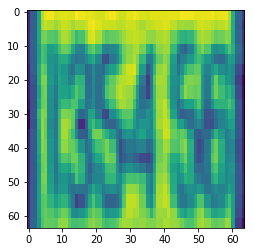

In [ ]:
plt.imshow(train_dataset[29929,:,:])
print(train_labels[29929])

In [ ]:
train_dataset = np.delete(train_dataset, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)

In [ ]:
test_dataset = Dataset(test_data, 'test')
test_dataset, test_labels = test_dataset.getDataset()

dataset: (13068, 64, 64)
labels: (13068, 5)


In [ ]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

In [ ]:
train_portion = 6000
valid_dataset = train_dataset[:train_portion,:,:]
valid_labels = train_labels[:train_portion]
train_dataset = train_dataset[train_portion:,:,:]
train_labels = train_labels[train_portion:]
                             
print(train_dataset.shape, train_labels.shape)
print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(27401, 64, 64) (27401, 5)
(13068, 64, 64) (13068, 5)
(6000, 64, 64) (6000, 5)


In [ ]:
def disp_sample_dataset(dataset, label):
    items = random.sample(range(dataset.shape[0]), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(label[i][0:5])
        plt.imshow(dataset[i,:,:])

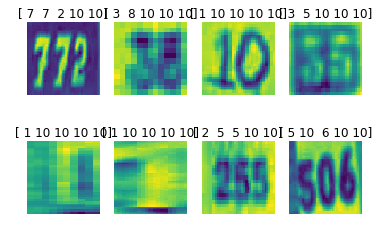

In [ ]:
disp_sample_dataset(train_dataset, train_labels)

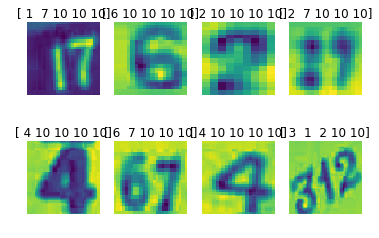

In [ ]:
disp_sample_dataset(test_dataset, test_labels)

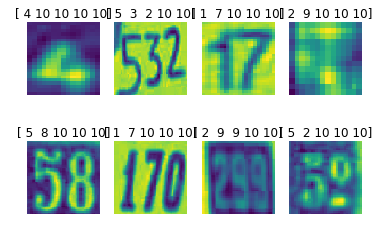

In [ ]:
disp_sample_dataset(valid_dataset, valid_labels)

In [ ]:
pickle_file = 'SVHN_multi_crop.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print("Done")
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Done


In [ ]:
from __future__ import print_function
import random
from os import listdir
import glob

import numpy as np
from scipy import misc
import tensorflow as tf
import h5py

from keras.datasets import mnist
from keras.utils import np_utils

from six.moves import cPickle as pickle
from six.moves import range


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [ ]:
random.seed(42)


## Load Dataset

In [ ]:
pickle_file = 'SVHN_multi_crop.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (27401, 64, 64) (27401, 5)
Validation set (6000, 64, 64) (6000, 5)
Test set (13068, 64, 64) (13068, 5)


Label for image: [ 7  5 10 10 10]


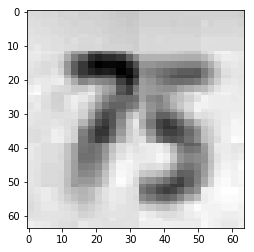

In [ ]:
plt.figure()
plt.imshow(train_dataset[50], cmap='gray')

print("Label for image: {}".format(train_labels[50]))

## Convert Labels
This function converts each digit label to one-hot array.

In [ ]:
possible_classes = 11

def convert_labels(labels):
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig3_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
    
    for index,label in enumerate(labels):
        dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
        dig2_arr[index,:] = np_utils.to_categorical(label[2],possible_classes)
        dig3_arr[index,:] = np_utils.to_categorical(label[3],possible_classes)
        dig4_arr[index,:] = np_utils.to_categorical(label[4],possible_classes)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr]

In [ ]:
train_labels = convert_labels(train_labels)
test_labels = convert_labels(test_labels)
valid_labels = convert_labels(valid_labels)

In [ ]:
np.shape(train_labels[0])

(27401, 11)

## Prepare Data for Keras
Reshape image data to be processed by Keras.

In [ ]:
def prep_data_keras(img_data):
    img_data = img_data.reshape(len(img_data), 64, 64, 1)
    img_data = img_data.astype('float32')
    img_data /= 255
    
    return img_data


In [ ]:
train_images = prep_data_keras(train_dataset)
test_images = prep_data_keras(test_dataset)
valid_images = prep_data_keras(valid_dataset)

In [ ]:
np.shape(train_images)

(27401, 64, 64, 1)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adadelta, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


## Build Model
Build Deep Learning model to process data.

In [ ]:
batch_size = 32
nb_classes = 11
nb_epoch = 24
img_rows = 64
img_cols = 64
img_channels = 1
nb_filters = 32
pool_size = (2, 2)
kernel_size = (3, 3)
inputs = Input(shape=(img_rows, img_cols, img_channels))
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(inputs)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)


cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)
cov_out = Flatten()(cov)
cov2 = Dense(2056, activation='relu')(cov_out)
cov2 = Dropout(0.3)(cov2)
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)
model = Model(inputs=inputs,outputs=[c0,c1,c2,c3,c4])
print (model.summary())
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(train_images,train_labels,batch_size=batch_size,epochs=nb_epoch,verbose=1,
          validation_data=(valid_images, valid_labels), callbacks=[early_stopping])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
predictions = model.predict(test_images)

In [ ]:
import keras
model.save('my_model.h5')

In [ ]:
x=keras.models.load_model('my_model.h5')

In [ ]:
x.predict(test_images)

[array([[1.85597894e-25, 9.99997735e-01, 5.11408360e-10, ...,
         1.75671722e-09, 6.65566631e-07, 1.04981744e-07],
        [3.74091246e-22, 2.42907760e-07, 3.34660549e-10, ...,
         8.63830646e-05, 5.71121852e-08, 2.75309731e-08],
        [2.80694331e-16, 3.84326238e-04, 9.96568561e-01, ...,
         5.27907605e-06, 2.08186987e-03, 1.55602481e-06],
        ...,
        [1.15515200e-30, 2.31229524e-06, 9.99975443e-01, ...,
         7.42288648e-08, 3.13147230e-10, 2.88618800e-19],
        [2.72623779e-18, 9.05744855e-06, 2.93058068e-01, ...,
         1.14788354e-05, 1.32906061e-04, 2.17849205e-08],
        [1.06858022e-10, 9.68621850e-01, 4.45410702e-03, ...,
         2.16232445e-02, 9.74377617e-04, 1.19049946e-04]], dtype=float32),
 array([[5.9390409e-25, 1.1032493e-03, 5.4611199e-08, ..., 3.4279968e-09,
         1.8156850e-09, 7.8672310e-06],
        [4.5182826e-23, 2.6631947e-10, 1.4101587e-10, ..., 5.6492505e-11,
         3.6991778e-11, 9.9999928e-01],
        [9.4972120e-17

In [ ]:
np.shape(test_labels)
print(predictions[0][0])
print(np.argmax(predictions[0][0]))

[2.3995954e-17 9.9984336e-01 1.4258625e-06 9.4024352e-07 7.2089015e-06
 4.4586536e-06 1.0816735e-05 1.0720759e-04 2.3667069e-06 2.1726873e-05
 4.6366750e-07]
1


## Calculate Accuracy
Custom accuracy calculation for individual digits and the whole sequence.

In [ ]:
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    coverage_counter = 0
    confidence = 0.7
    for i in range(0,len(predictions[0])):
        # Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter += 1
            if predictions[j][i][np.argmax(predictions[j][i])] >= confidence:
                coverage_counter += 1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter / float(len(predictions[0]) * 5)
    global_accuracy = global_sequence_counter / float(len(predictions[0]))
    coverage = coverage_counter / float(len(predictions[0]) * 5)
    
    return ind_accuracy,global_accuracy, coverage

In [ ]:
ind_acc, glob_acc, coverage = calculate_acc(predictions, test_labels)

In [ ]:
print("The individual accuracy is {} %".format(ind_acc * 100))
print("The sequence prediction accuracy is {} %".format(glob_acc * 100))
print("The coverage is {} %".format(coverage * 100))

The individual accuracy is 96.5243342516 %
The sequence prediction accuracy is 86.0728497092 %
The coverage is 96.45087236 %


Actual labels: [2, 7, 2, 10, 10]
Predicted labels: [4, 10, 10, 10, 10]

Actual labels: [4, 5, 10, 10, 10]
Predicted labels: [4, 5, 10, 10, 10]

Actual labels: [6, 2, 10, 10, 10]
Predicted labels: [6, 2, 10, 10, 10]

Actual labels: [4, 8, 10, 10, 10]
Predicted labels: [4, 8, 10, 10, 10]

Actual labels: [2, 1, 6, 10, 10]
Predicted labels: [2, 1, 6, 10, 10]



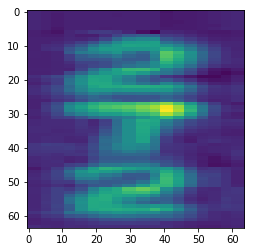

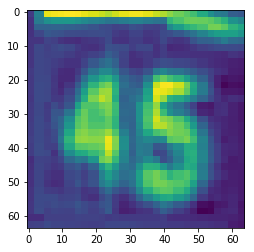

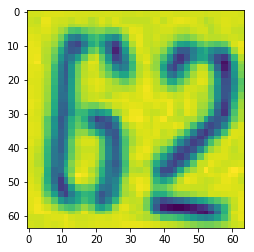

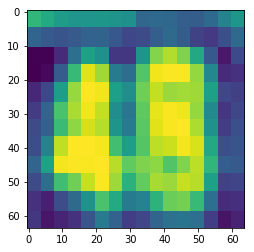

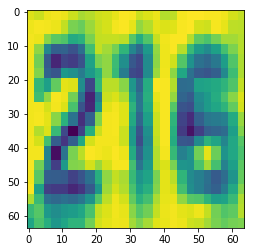

In [ ]:
for i in random.sample(range(0,10000),5):
    
    actual_labels = []
    predicted_labels = []
    plt.figure()
    plt.imshow(test_dataset[i])
    for j in range(0,5):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
        
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))